<a href="https://colab.research.google.com/github/HUJH511/SEACAS-2023-SG/blob/main/SEACAS_2023_SG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEACAS Hackathon 2023:

## Team: **Singapore**

About:

This iPython Notebook contains a design flow on OpenLane of the baseline FFT implementation, which can be found [here](https://github.com/ameyk1/Fast-Fourier-Transform/tree/master).

First, we'll need to clone this github repository and transfer the files to the root folder of the colab runtime.

## Evaluation Metrics

The results will be evaluated using the following metrics, most of which you will obtain at the end:

1.   CoreArea_um^2
2.   power_typical_switching_uW
3.   power_typical_internal_uW
4.   suggested_clock_period
5.   **time at `$finish` in ns**. Please do `$display("Final time: %0t",$time);` before calling `$finish`.
6.   **16-point output signal**, as shown with the sample baseline testbench.

Ideally, your design should have no DRC or LVS errors:

1.   lvs_total_errors = 0
2.   Magic_violations = 0
3.   klayout_violations = -1

Please include all of these in the final report presentation!

In [ ]:
!git clone https://github.com/ameyk1/Fast-Fourier-Transform.git
!mv Fast-Fourier-Transform/rtl/* .
!mkdir tb
!mv Fast-Fourier-Transform/matlab/data_in.m tb/

fatal: destination path 'Fast-Fourier-Transform' already exists and is not an empty directory.
mv: cannot stat 'Fast-Fourier-Transform/rtl/*': No such file or directory
mkdir: cannot create directory ‘tb’: File exists
mv: cannot stat 'Fast-Fourier-Transform/matlab/data_in.m': No such file or directory


In [ ]:
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

openlane_version = '2023.07.25_2_g01e67230' #@param {type:"string"}
openroad_version = '2.0_9484_g353633e01' #@param {type:"string"}
open_pdks_version = '1.0.428_2_g405227f' #@param {type:"string"}

if openlane_version == 'latest':
  openlane_version = ''
if open_pdks_version == 'latest':
  open_pdks_version = ''
if openroad_version == 'latest':
  openroad_version = ''

import os
import pathlib
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     openlane={openlane_version} \
                     open_pdks.sky130a={open_pdks_version} \
                     openroad={openroad_version} \
                     iverilog
!python -m pip install gdstk gdstk
PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}


Empty environment created at prefix: /content/conda-env

Pinned packages:
  - python 3.7*


Transaction

  Prefix: /content/conda-env

  Updating specs:

   - openlane=2023.07.25_2_g01e67230
   - open_pdks.sky130a=1.0.428_2_g405227f
   - openroad=2.0_9484_g353633e01
   - iverilog


  Package                              Version  Build                 Channel         Size
────────────────────────────────────────────────────────────────────────────────────────────
  Install:
────────────────────────────────────────────────────────────────────────────────────────────

  + open_pdks.sky130a       1.0.428_2_g405227f  20230724_080446       litex-hub     Cached
  + _libgcc_mutex                          0.1  main                  main          Cached
  + libstdcxx-ng                        11.2.0  h1234567_1            main          Cached
  + ca-certificates                 2023.08.22  h06a4308_0            main          Cached
  + ld_impl_linux-64                      2.38  h1181459_1      

# iVerilog and Behavioral Simulations

If you are used to running verilog and you would like to perform the behavioral simulations offline, please visit the [IVerilog & GTKWave tutorial](https://cidr.up-microlab.org/index.php/IVerilog_GTKWave_Tutorial#Viewing_the_output_VCD_using_GTKWave) instead.

We start with by running simulations with Icarus Verilog.

## Writing the Verilog files

While we already have the RTL files, we need a generate a testbench to run this RTL code. This is an edited version of the testbench from the repository.

In [ ]:
%%writefile tb/fft_top_tb.v

`timescale 1ns/1ps

//////////////////////////////////////////////////////////////////////////////////
// Engineer: Amey Kulkarni
// Design Name: Fast Fourier Transform (16-point)
// Module Name:  fft_top_tb
// Project Name: Fast Fourier Transform (16-point)
//////////////////////////////////////////////////////////////////////////////////

module fft_top_tb;

   /****************************************************************************
    * Signals
    ***************************************************************************/

   reg                clk;
   reg                reset;

   reg                in_push;
   reg signed [15:0]  in_real;
   reg signed [15:0]  in_imag;
   wire               in_stall;

   wire               out_push;
   wire signed [15:0] out_real;
   wire signed [15:0] out_imag;
   reg                out_stall;

   integer            i;
   integer            r;



   /****************************************************************************
    * Generate Clock Signals
    ***************************************************************************/

   // 250 MHz clock
   initial clk = 1'b1;
   always #2 clk = ~clk;

   /****************************************************************************
    * Instantiate Modules
    ***************************************************************************/

   fft_top fft_top_0 (
      .clk        (clk),
      .reset      (reset),
      .in_push    (in_push),
      .in_real    (in_real),
      .in_imag    (in_imag),
      .in_stall   (in_stall),
      .out_push_F (out_push),
      .out_real_F (out_real),
      .out_imag_F (out_imag),
      .out_stall  (out_stall)
   );

   /****************************************************************************
    * Apply Stimulus
    ***************************************************************************/

   // Record the input data.
   initial begin: RECORD_INPUT

      integer input_file;
      integer count;

      count = 0;

      input_file = $fopen("tb/data_in.m", "w");

      $fdisplay(input_file, "Testing...");
            $fdisplay(input_file, "Testing...");

      while (count < 16) begin

         if (in_push === 1'b1 && in_stall === 1'b0) begin

            $display("in(%0d) = %0d + i*%0d;",
               count + 1, in_real, in_imag);

            $fdisplay(input_file, "in(%0d) = %0d + i*%0d;",
               count + 1, in_real, in_imag);

            count = count + 1;

         end

         //this is posedge in the original code, causing it to skip the first data point
         //being delayed by a single clock cycle, causing the wrong output.
         @(negedge clk);

      end

   end

   // Record the output data.
   initial begin: RECORD_OUTPUT

      integer output_file;
      integer count;
      integer j;

      count = 0;

      output_file = $fopen("tb/data_out.m");

      while (count < 16) begin

         @(posedge clk);

         if (out_push === 1'b1 && out_stall === 1'b0) begin

            $display("out(%0d) = %0d + i*%0d;",
               count + 1, out_real, out_imag);

            $fwrite(output_file, "out(%0d) = %0d + i*%0d;\n",
               count + 1, out_real, out_imag);

            count = count + 1;

         end

      end

   end

   // Apply stimulus.
   initial begin

      $dumpfile("sim.vcd");
      $dumpvars(0,fft_top_tb);
      repeat (1) @(posedge clk);

      reset = 1'b1;
      repeat (2) @(posedge clk);

      reset = 1'b0;
      in_push = 1'b0;
      in_real = 0;
      in_imag = 0;
      out_stall = 0;
      repeat (1) @(posedge clk);

      $display("Pushing input...");

      for (i = 0; i < 16; i = i+1) begin

         in_push = 1'b1;

         in_real = (i == 0)? 16'h7fff : 0;
         in_imag = 0;

         repeat (1) @(posedge clk);

      end

      in_push = 1'b0;
      $display("Done pushing inputs. Waiting for outputs...");
      repeat (1) @(posedge clk);

      for (i = 0; i < 16; i = i+1) begin

         while (out_push == 1'b0)
            @(posedge clk);

         @(posedge clk);

      end

      repeat (5) @(posedge clk);

      $finish;

   end

endmodule

Overwriting tb/fft_top_tb.v


## Behavioral Simulation

Feel free to download and run this offline if you'd like to see the value-change dump in GTKWave.

We test the RTL by taking the FFT of a scaled impulse.

In [ ]:
!iverilog -o dsn tb/fft_top_tb.v *.v

In [ ]:
!vvp dsn

VCD info: dumpfile sim.vcd opened for output.
Pushing input...
in(1) = 32767 + i*0;
in(2) = 0 + i*0;
in(3) = 0 + i*0;
in(4) = 0 + i*0;
in(5) = 0 + i*0;
in(6) = 0 + i*0;
in(7) = 0 + i*0;
in(8) = 0 + i*0;
in(9) = 0 + i*0;
in(10) = 0 + i*0;
in(11) = 0 + i*0;
in(12) = 0 + i*0;
in(13) = 0 + i*0;
in(14) = 0 + i*0;
in(15) = 0 + i*0;
in(16) = 0 + i*0;
Done pushing inputs. Waiting for outputs...
out(1) = 2047 + i*0;
out(2) = 2047 + i*0;
out(3) = 2047 + i*0;
out(4) = 2047 + i*0;
out(5) = 2047 + i*0;
out(6) = 2047 + i*0;
out(7) = 2047 + i*0;
out(8) = 2047 + i*0;
out(9) = 2047 + i*0;
out(10) = 2047 + i*0;
out(11) = 2047 + i*0;
out(12) = 2047 + i*0;
out(13) = 2047 + i*0;
out(14) = 2047 + i*0;
out(15) = 2047 + i*0;
out(16) = 2047 + i*0;
tb/fft_top_tb.v:175: $finish called at 292000 (1ps)


# RTL (Verilog) to Layout (GDS) with OpenLane

To turn the (non-testbench) verilog files into a layout, we use the **OpenLane** toolset. The cells below are credited to Prof. Bui.

We run our simple counter design through [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) GDS to RTL flow targeting the [open source SKY130 PDK](https://github.com/google/skywater-pdk/).

## Write Configuration File

Next, we have to write a configuration file for OpenLane to know the settings for the current run. The possible settings are documented in the [OpenLane documentation](https://openlane.readthedocs.io/en/latest/reference/configuration.html)

In the config file below, we:
*   Tell OpenLane the design name, which should be the name of your top-level module in your verilog code (*ctr*, in this case).
*   List the input verilog files.
*   Tell it to find the pin order configuration in a separate file (which we will make soon)
*   Give a bunch of other settings for the layout

For the baseline, we importantly specify that the core utilization is 20%, allowing ample space for routing without having the layout be too large.

In [ ]:
%%writefile config.json
{
    "DESIGN_NAME": "fft_top",
    "VERILOG_FILES": "dir::*.v",
    "CLOCK_PORT": "clk",
  	"FP_PIN_ORDER_CFG": "dir::pin_order.cfg",
	  "FP_PDN_VOFFSET": 7,
	  "FP_PDN_HOFFSET": 7,
	  "FP_PDN_SKIPTRIM": true,
  	"FP_CORE_UTIL": 20,
  	"CLOCK_PERIOD": 10.0,
  	"DESIGN_IS_CORE": true
}

Overwriting config.json


Next, we write down the pin order configurations, which we promised to give OpenLane (in the configuration written above). We specify the CLK and nrst pins to be on the west, while all pins of ctr_out is on the right.

In [ ]:
%%writefile pin_order.cfg
#W
clk
reset
in_push
in_real.*
in_imag.*
out_stall
#E
in_stall
out_push_F
out_real_F.*
out_imag_F.*

Overwriting pin_order.cfg


## Run OpenLane Flow

Next, we run the OpenLane flow.

[OpenLane](https://openlane.readthedocs.io/en/latest/) is an automated [RTL](https://en.wikipedia.org/wiki/Register-transfer_level) to [GDSII](https://en.wikipedia.org/wiki/GDSII) flow based on several components including [OpenROAD](https://theopenroadproject.org/), [Yosys](https://yosyshq.net/yosys/), [Magic](http://www.opencircuitdesign.com/magic/), [Netgen](http://opencircuitdesign.com/netgen/) and custom methodology scripts for design exploration and optimization targeting [open source PDKs](https://github.com/google/open-source-pdks).

![img](https://openlane.readthedocs.io/en/latest/_images/flow_v1.png)

We set the target PDK to be Skywater 130nm A, an open-source PDK and then run the OpenLane flow (compiled as a bunch of tcl commands). Running the entire tool flow can take more than an hour for big designs.

This flow will also mention if your code has Design Rule (DRC) or Layout-vs-Schematic (LVS) errors, none of which should be present in your design according to the specs of the Chipathon.

If you encounter these errors, you may need to recheck your verilog code to make less complex blocks or use better coding practices.

In [ ]:
%env PDK=sky130A
!flow.tcl -design .

env: PDK=sky130A
OpenLane 2023.07.25_2_g01e67230-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]: Process Design Kit: sky130A
[INFO]: Standard Cell Library: sky130_fd_sc_hd
[INFO]: Optimization Standard Cell Library: sky130_fd_sc_hd
[INFO]: Run Directory: /content/runs/RUN_2023.09.18_05.01.29
[INFO]: Saving runtime environment...
[INFO]: Preparing LEF files for the nom corner...
[INFO]: Preparing LEF files for the min corner...
[INFO]: Preparing LEF files for the max corner...
[INFO]: Running linter (Verilator) (log: runs/RUN_2023.09.18_05.01.29/logs/synthesis/linter.log)...
[INFO]: 0 errors found by linter
[INFO]: 0 warnings found by linter
[STEP 1]
[INFO]: Running Synthesis (log: runs/RUN_2023.09.18_05.01.29/logs/synthesis/1-synthesis.log)...
[STEP 2]
[INFO]: Runni

## Display Layout

Finally, we display the final layout results.

The final layout should be found in `runs/results/final/ctr.gds`

We can use KLayout to view a PNG of the final layout by running the following code:

Final GDS: runs/RUN_2023.09.18_05.01.29/results/final/gds/fft_top.gds
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   958  100   958    0     0   5637      0 --:--:-- --:--:-- --:--:--  5668
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1655  100  1655    0     0   9771      0 --:--:-- --:--:-- --:--:--  9792
Using Techfile: /content/conda-env/share/pdk/sky130A/libs.tech/klayout/tech/sky130A.lyt
Using layout file: runs/RUN_2023.09.18_05.01.29/results/final/gds/fft_top.gds
[INFO] Reading tech file: /content/conda-env/share/pdk/sky130A/

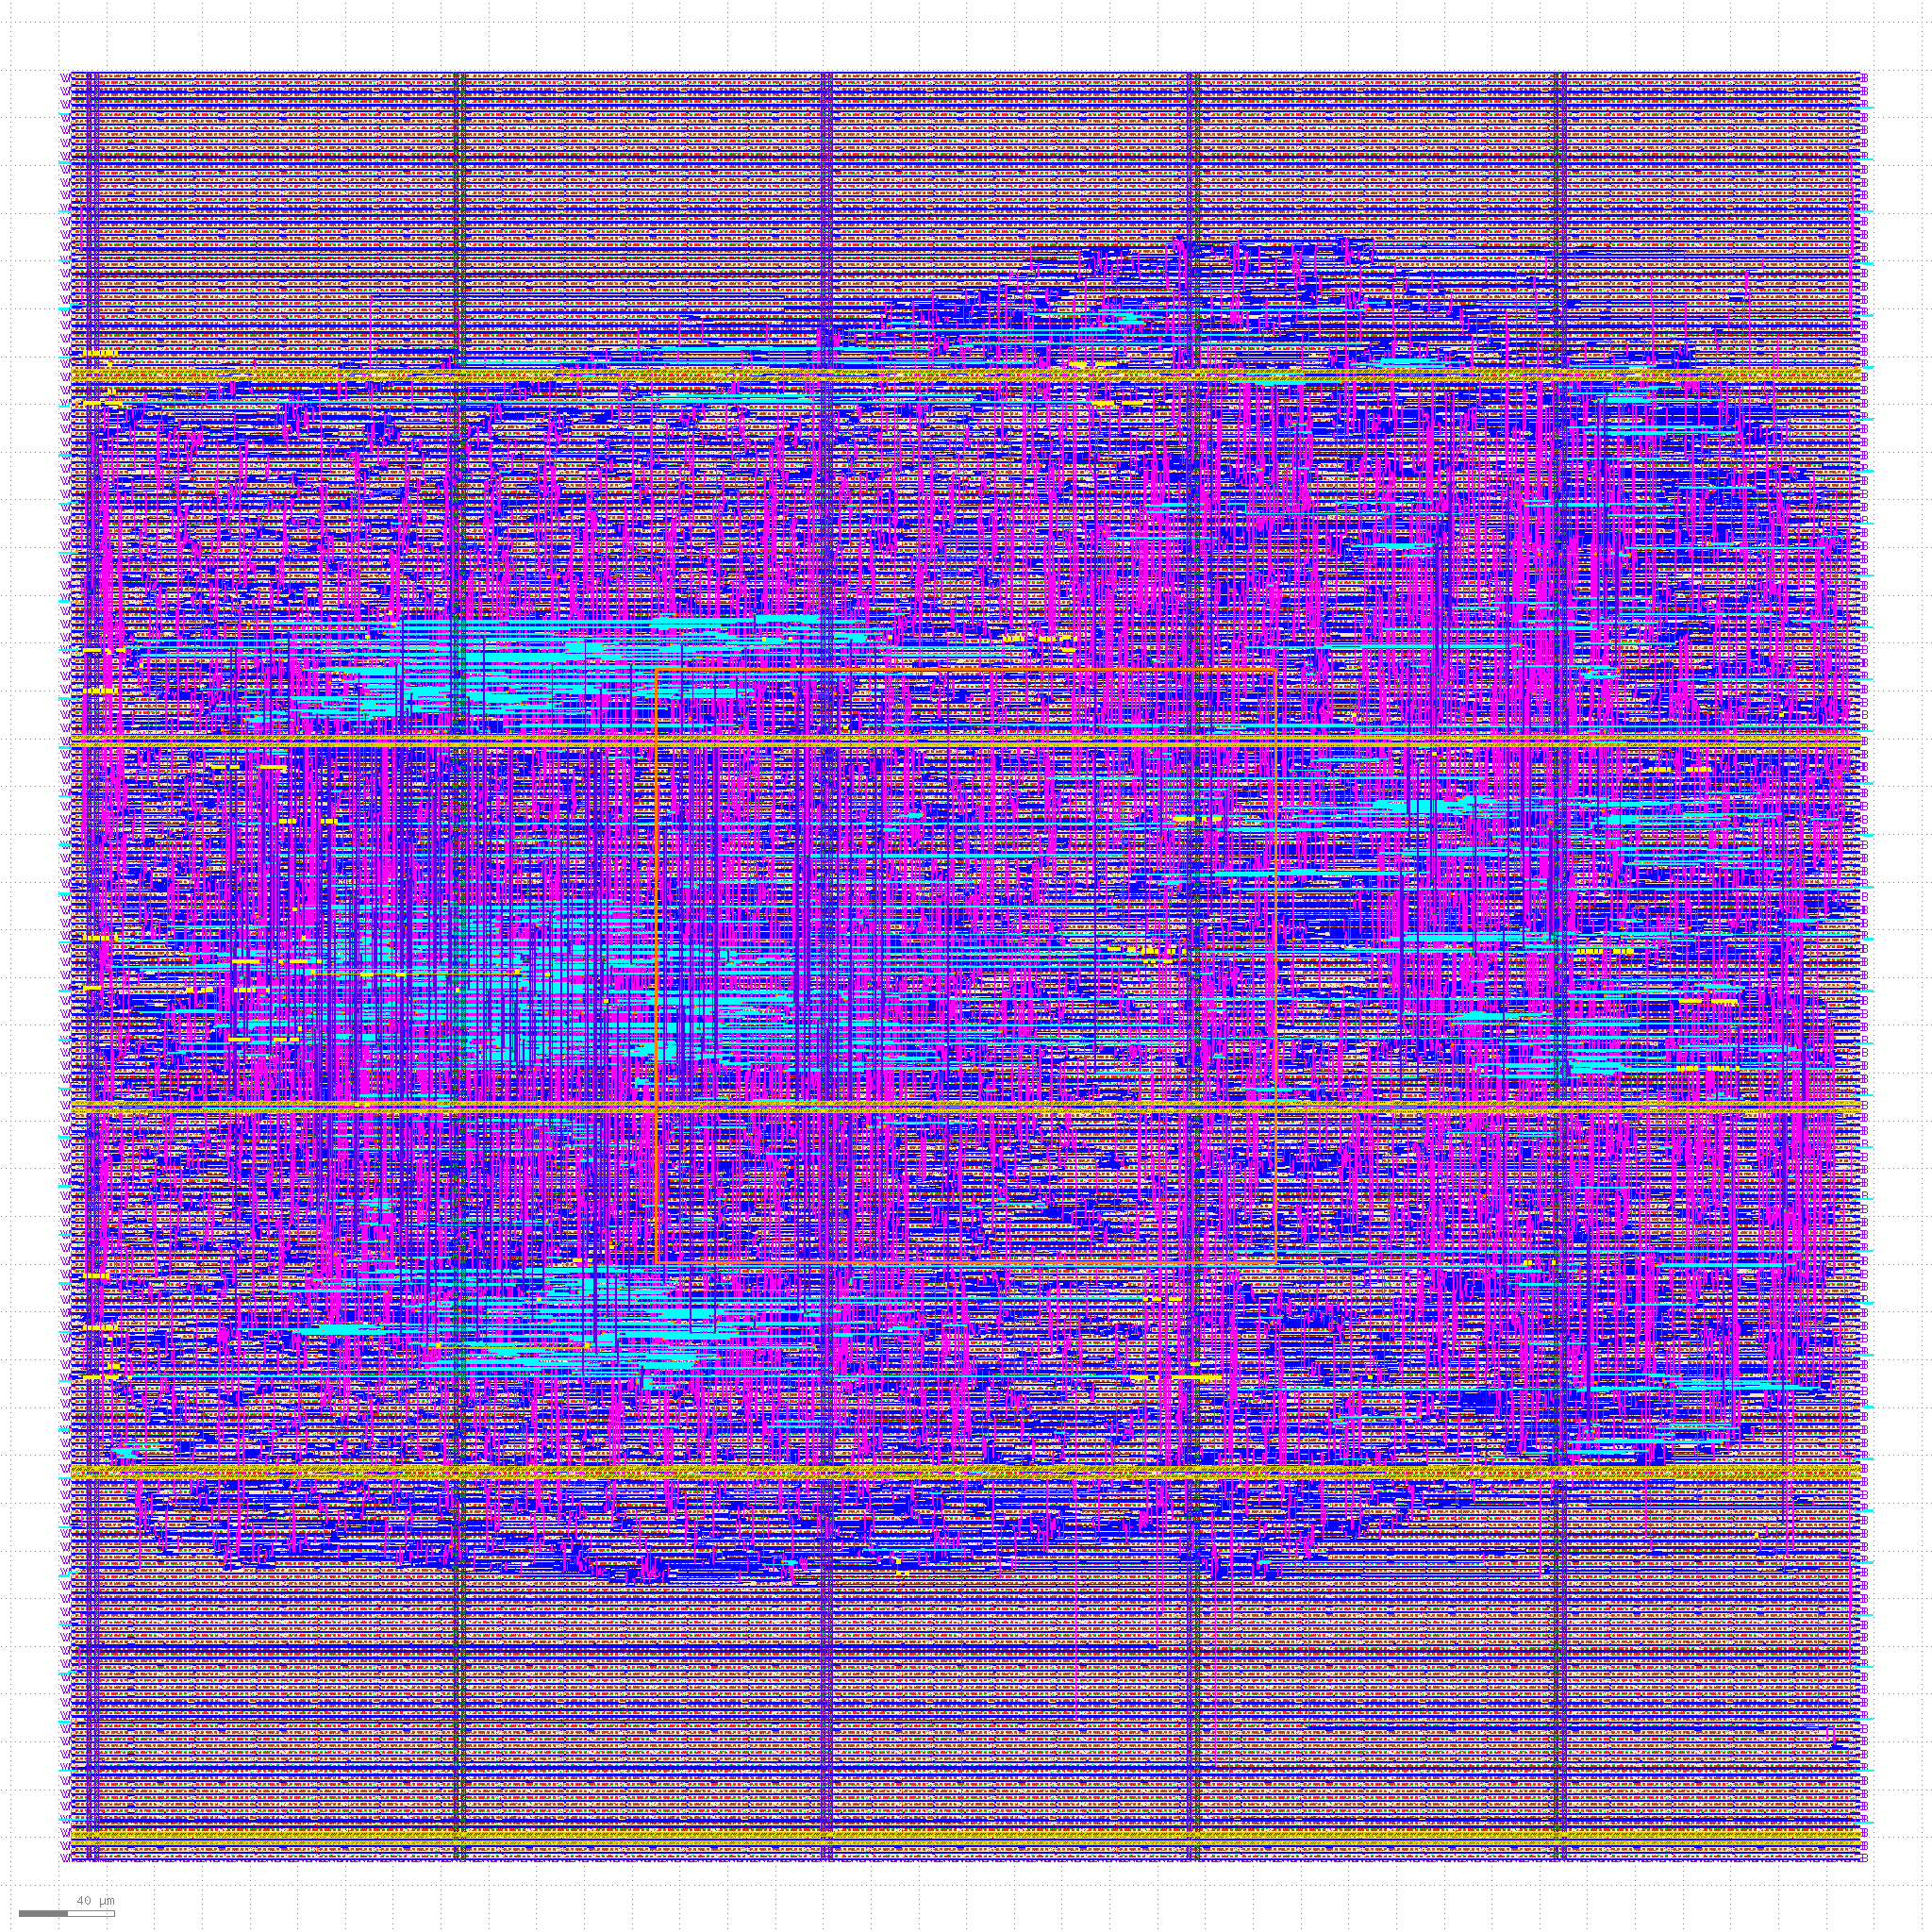

In [ ]:
import pathlib
import gdstk
import IPython.display

gdss = sorted(pathlib.Path('runs').glob('*/results/final/gds/*.gds'))
gds_path = "%s" % gdss[-1]
print("Final GDS: %s" % gds_path)

!apt install xvfb
!curl https://raw.githubusercontent.com/The-OpenROAD-Project/OpenLane/mpw-6b/scripts/klayout/scrotLayout.sh -o scrotLayout.sh
!curl https://raw.githubusercontent.com/The-OpenROAD-Project/OpenLane/mpw-6b/scripts/klayout/scrotLayout.py -o scrotLayout.py
!bash scrotLayout.sh /content/conda-env/share/pdk/sky130A/libs.tech/klayout/tech/sky130A.lyt {gds_path}

IPython.display.Image(gds_path + ".png")

You can also download the final `.gds` file for the layout using the following code snippet. *Skip this if you are running the notebook from your own PC*

In [ ]:
from google.colab import files
files.download(gds_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

You can use KLayout on your own PC to view the final layout in an interactive manner from the `.gds` file. You may download KLayout from the [website](https://www.klayout.de/build.html).

Once you have KLayout downloaded, you can open KLayout and open the .gds file using *File > Open*,

To view the layout with useful layer information (like layer names), you can download this [Layer Properties File](https://github.com/laurentc2/SKY130_for_KLayout/blob/main/SKY130.lyp) from Github and then open it from KLayout with *File > Load Layer Properties*.

## Metrics

Use the code below to view the performance metrics of your design

In [ ]:
import pandas as pd
import pathlib

pd.options.display.max_rows = None
reports = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(reports[-1])
df.transpose()

,0
design,/content
design_name,fft_top
config,RUN_2023.09.18_05.01.29
flow_status,flow completed
total_runtime,0h24m49s0ms
routed_runtime,0h17m33s0ms
(Cell/mm^2)/Core_Util,94635.031683
DIEAREA_mm^2,0.585143
CellPer_mm^2,18927.006337
OpenDP_Util,20.46


## Figure of Merit

Run the code below to calculate your work's figure of merit. Replace the latency variable with the time of your simulation at $finish.

In [ ]:
# PLACE YOUR LATENCY HERE IN NS (called at finish time)
latency = 292 #In this baseline, it was 292000 (1ps), so we divide by 1000.

power = df['power_typical_switching_uW'] + df['power_typical_internal_uW']
area = df['CoreArea_um^2']

# Metric should be as low as possible
FoM = latency * power * area
print(f'The design FoM is: {FoM.to_numpy()[0]}')

The design FoM is: 3758104.0935328


# Using your own code

You may replace the code verilog codes above with your own code, or upload .v files to the "files" inside Colab (folder icon on the left) and run the code above on those.

Of course, you'll have to edit the config files. The workflow will be as follows:

1. Upload .v files
2. Run iverilog and vvp on your verilog files & testbench
3. Edit the OpenLane config file config.json with your design name, verilog file names.
4. Edit the pin orders file pin_order.cfg with your top-level input and output pins.

An example by Prof. Duy-Hieu Bui of this tool flow with a bigger design can be found in the [GCD Example](https://colab.research.google.com/drive/14GOFCUxp1P3dBOVYN1-kW5XjANir56yA?usp=sharing)

## ! IMPORTANT NOTE !

Note that any changes to this notebook (like your own verilog code) cannot be saved. I would recommend having an offline version of your verilog codes, or making a copy of this notebook in your own google drive in order to be able to save changes.

# Contacts

For any concerns about this tool flow or tutorials, contact lawrence.quizon@eee.upd.edu.ph

For other concerns, like accommodation, please contact seacas2023@eee.upd.edu.ph
